# Familienfinder
- Features: a, e, i

- Das Ziel: Asteroidenfamilien finden.

- Warum? Wenn Asteroiden vor Jahrmillionen durch eine Kollision entstanden sind, haben sie oft sehr ähnliche Bahnelemente (a, e, i), auch wenn sie heute weit verstreut wirken. Ein Cluster-Algorithmus kann diese "Geschwister" wieder zusammenführen.


In [3]:
from sklearn.cluster import KMeans
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats
%matplotlib inline

# Load and Sort

/var/folders/tv/kwzyy9z51hl6kg2pqz9rjhz00000gn/T/ipykernel_71161/3163474433.py:1: DtypeWarning: Columns (17,23,24,25,36,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('allData.csv')


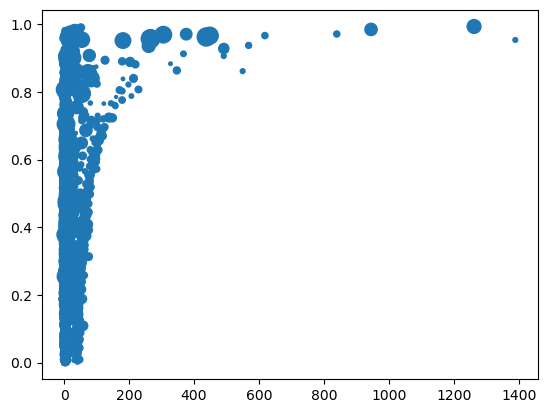

In [4]:
df = pd.read_csv('allData.csv')

features = ['a', 'e', 'i']
X = df[features].dropna()

X.head()
plt.scatter(X['a'],X['e'],X['i']) 

# Scale

In [5]:
scaler = MinMaxScaler()
scaler.fit(X[["a"]])
X['a'] = scaler.transform(X[['a']])

scaler.fit(X[['e']])
X['e'] = scaler.transform(X[['e']])

scaler.fit(X[['i']])
X['i'] = scaler.transform(X[['i']])

X.head()

,a,e,i
0,0.001592,0.080044,0.060124
1,0.001595,0.232078,0.198443
2,0.001524,0.257451,0.073763
3,0.001301,0.090717,0.040518
4,0.001456,0.188683,0.030403


# Elbow Technique

/Users/philippstorz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/philippstorz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/philippstorz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/philippstorz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

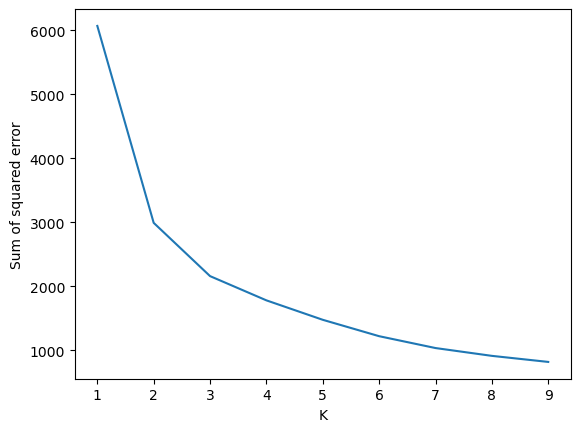

In [6]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X[['a','e','i']])
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

# Cluster and Predict

In [7]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(X[['a','e','i']])
y_predicted
X['cluster'] = y_predicted
X.head()

/Users/philippstorz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,a,e,i,cluster
0,0.001592,0.080044,0.060124,0
1,0.001595,0.232078,0.198443,1
2,0.001524,0.257451,0.073763,1
3,0.001301,0.090717,0.040518,0
4,0.001456,0.188683,0.030403,2


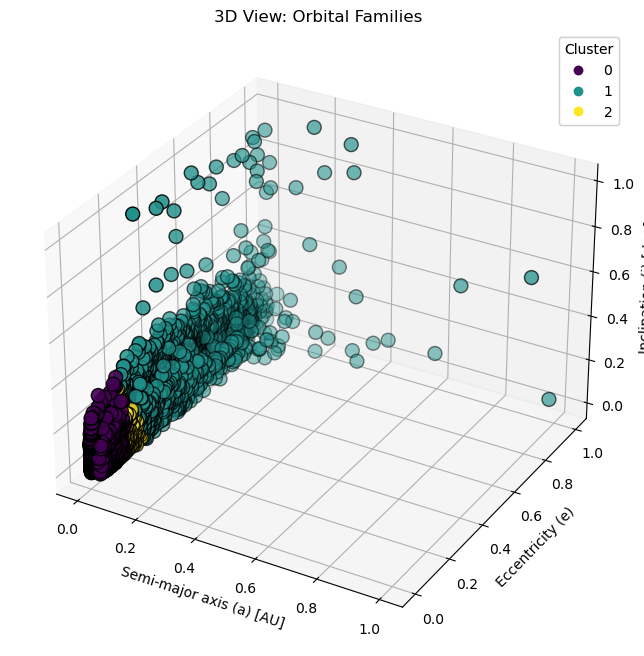

In [8]:
# Setup figure
fig = plt.figure(figsize=(18, 8))

# 3D Scatter
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X['a'], X['e'], X['i'], c=X['cluster'], cmap='viridis', s=100, edgecolor='k')
ax1.set_xlabel('Semi-major axis (a) [AU]')
ax1.set_ylabel('Eccentricity (e)')
ax1.set_zlabel('Inclination (i) [deg]')
ax1.set_title('3D View: Orbital Families')
legend1 = ax1.legend(*scatter.legend_elements(), title="Cluster")
ax1.add_artist(legend1)

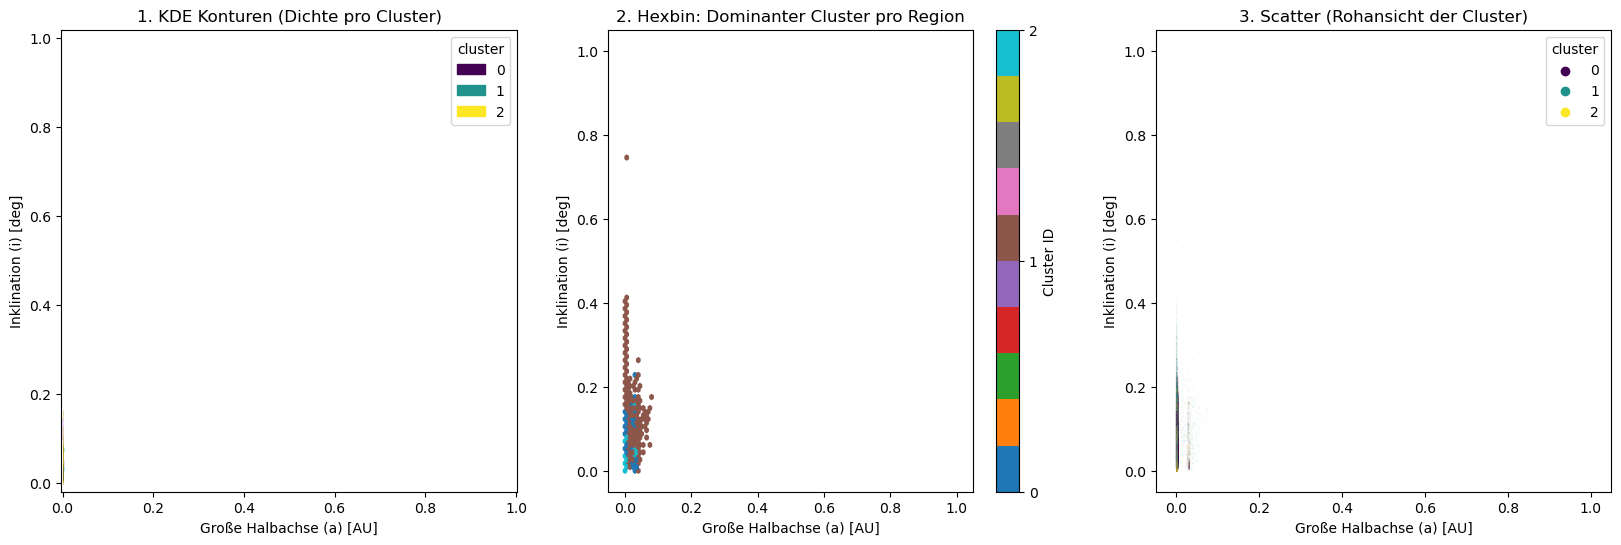

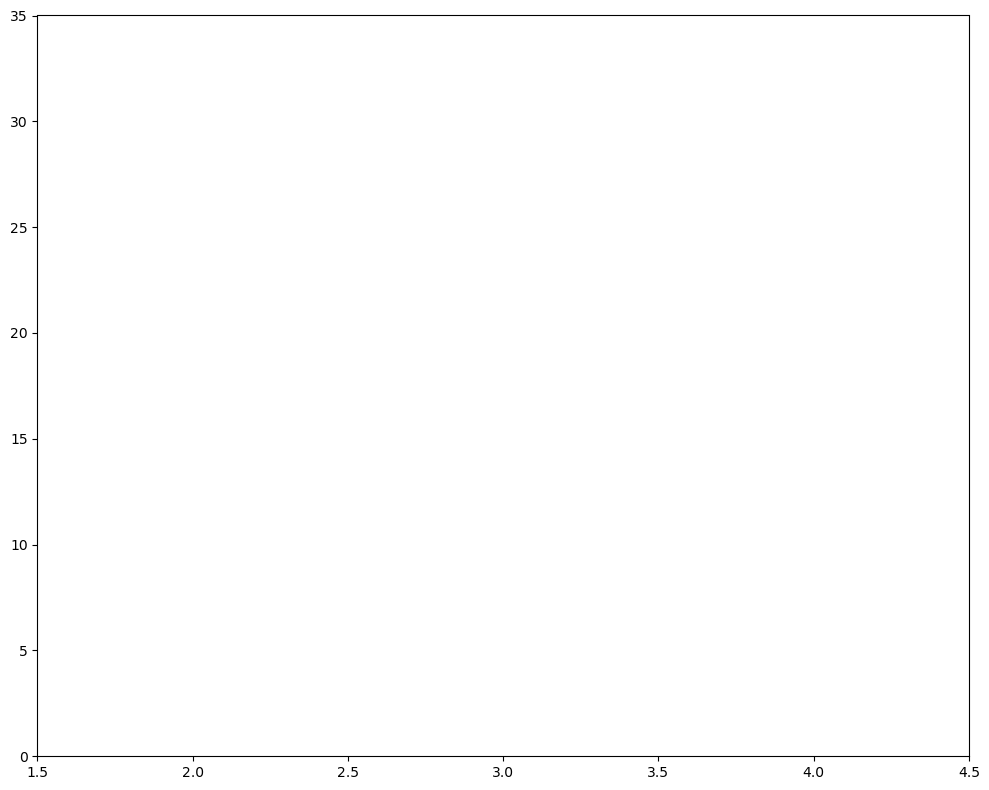

In [11]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.figure(figsize=(10, 8))
sns.kdeplot(
    data=X, 
    x='a', y='i', 
    hue='cluster', 
    palette='viridis', 
    fill=True, 
    alpha=0.5, 
    ax=axes[0]
)
axes[0].set_title('1. KDE Konturen (Dichte pro Cluster)')
plt.xlim(1.5, 4.5)  # Zoome auf 1.5 AU bis 4.5 AU (Hauptgürtel)
plt.ylim(0, 35)

def get_dominant_cluster(x):
    # Hilfsfunktion, die den Modus (häufigsten Wert) in der Wabe findet
    if len(x) == 0: return np.nan
    return stats.mode(x, keepdims=False)[0]

hb = axes[1].hexbin(
    X['a'], X['i'], 
    C=X['cluster'],   
    reduce_C_function=get_dominant_cluster, 
    gridsize=100, # Bei 800k: gridsize=100 oder mehr
    cmap='tab10',      
    mincnt=1
)
axes[1].set_title('2. Hexbin: Dominanter Cluster pro Region')
cb = plt.colorbar(hb, ax=axes[1], ticks=np.arange(4))
cb.set_label('Cluster ID')


# --- PLOT 3: Scatter mit Alpha (Rohansicht der Cluster) ---
# Zeigt die tatsächliche Verteilung der Punkte (Sampling ist PFLICHT bei großen Daten)
sns.scatterplot(
    data=X, 
    x='a', y='i', 
    hue='cluster', 
    palette='viridis', 
    s=1, # Bei 800k: s=1
    alpha=0.05, # Bei 800k: alpha=0.05
    ax=axes[2], 
    legend='full'
)
axes[2].set_title('3. Scatter (Rohansicht der Cluster)')


# Finales Layout anpassen
for ax in axes:
    ax.set_xlabel('Große Halbachse (a) [AU]')
    ax.set_ylabel('Inklination (i) [deg]')

plt.tight_layout()
plt.show()


# Export CSV

In [10]:
#X.to_csv('clustered_families.csv', index=False)
print(X[['a', 'i']].describe(percentiles=[0.999]))

                   a              i
count  875653.000000  875653.000000
mean        0.001613       0.049858
std         0.002523       0.034711
min         0.000000       0.000000
50%         0.001527       0.041768
99.9%       0.027951       0.200432
max         1.000000       1.000000


## Was war das Problem, warum der Plot nicht geklappt hat 

- Der Outlier-Effekt: Du hast Asteroiden mit extrem großer Halbachse (a) im Datensatz (wahrscheinlich Transneptunische Objekte mit a>100 oder a>1000 AU).

Der MinMaxScaler: Dieser Skalierer quetscht alles in den Bereich 0 bis 1.

        Wenn dein größtes a=1000 AU ist, wird dieses zu 1.0.

        Deine echten Hauptgürtel-Asteroiden (bei ca. 2.7 AU) werden zu 2.7/1000=0.0027.

Beweis in deinen Daten: Dein Print-Output sagt: 50% (Median) deiner Daten liegen bei 0.0015. Das bedeutet, deine komplette Punktewolke klebt bei fast Null auf der x-Achse. Gleichzeitig setzt du im Plot plt.xlim(1.5, 4.5). Ergebnis: Dein Plot zoomt auf einen leeren Bereich, weil deine (skalierten) Daten alle bei 0.002 liegen.

Du musst drei Dinge ändern:

    Filtern: Schmeiß die extremen Ausreißer raus, bevor du skalierst (oder benutze RobustScaler). Für Familien im Hauptgürtel interessiert dich alles über 10 AU nicht.

    StandardScaler: Nimm lieber StandardScaler (z-score) statt MinMaxScaler für diese Art von physikalischen Daten.

    Originaldaten Plotten: Cluster auf den skalierten Daten, aber plotte die Originaldaten (die echten AU-Werte), damit deine Achsen (1.5 bis 4.5) Sinn ergeben.
    